## Preprocessing 

#### if the MR is in dicom 

In [ ]:
## place the dicom images in the data/dicom folder

## run the following command to convert the dicom images to nifti images
!python ./preprocessing/dicomtonifti_2.py -i ./data/dicom -o ./data/unprocessed


Looking for DICOM series in: /media/data/BrainIAC/src/BrainIAC/data/dicom
Found 2 potential scan directories
Converting scans: 100%|███████████████████████████| 2/2 [00:00<00:00, 15.50it/s]

Conversion Summary:
Successfully converted: 2 scans
Failed conversions: 0 scans
Output directory: /media/data/BrainIAC/src/BrainIAC/data


#### if the MRs are in nifti 

In [ ]:
"""
Preprocess MRI images using the BrainIAC preprocessing pipeline.

3D MRI preprocessing includes:
- Registration to template space using the provided template image
- Skull stripping and brain extraction

Parameters:
    --temp_img: Path to template image for registration (./preprocessing/atlases/temp_head.nii.gz)
    --input_dir: Directory containing unprocessed NIfTI images (./data/sample/unprocessed)
    --output_dir: Directory to save processed images (./data/sample/processed)

Expected input: Raw NIfTI (.nii.gz) files in the input directory
Expected output: Preprocessed NIfTI files
"""
 
!python ./preprocessing/mri_preprocess_3d_simple.py \
--temp_img ./preprocessing/atlases/temp_head.nii.gz \
--input_dir ./data/sample/unprocessed \
--output_dir ./data/sample/processed

## BrainIAC - Feature Extraction

In [1]:
"""
Extract BrainIAC backbone features from preprocessed MRI images.

This script uses the BrainIAC backbone (Vit-B) to extract latent
feature representations from brain MRI scans. 

Parameters:
    --checkpoint: Path to the BrainIAC checkpoint
    --input_csv: CSV file containing scan IDs and labels (format: pat_id, label)
    --output_csv: Output path for extracted features CSV file
    --root_dir: Directory containing preprocessed NIfTI images

Expected input: Preprocessed NIfTI files and corresponding CSV 
Expected output: CSV file with extracted feature vector
"""

!python get_brainiac_features.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/sample.csv \
    --output_csv ./inference/features/features.csv \
    --root_dir ./data/sample/processed

Backbone weights loaded!!
Extracting ViT features: 100%|█████████████████| 1/1 [00:00<00:00,  2.90batch/s]
ViT BrainIAC features saved to ./inference/features/features.csv
Feature shape: (1, 769)
Number of feature dimensions: 768


## BrainIAC - Saliency map geneation 

In [ ]:
"""
Generate saliency maps using the BrainIAC backbone, from the last attention layer.

Parameters:
    --checkpoint: Path to the BrainIAC checkpoint
    --input_csv: CSV file containing scan IDs and labels (format: pat_id, label)
    --output_dir: Directory to save generated saliency maps
    --root_dir: Directory containing preprocessed NIfTI images

Expected input: Preprocessed NIfTI files and corresponding CSV
Expected output: Saliency map NIfTI files 
"""

!python get_brainiac_saliencymap.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/sample.csv \
    --output_dir ./inference/saliency_maps \
    --root_dir ./data/sample/processed

Backbone weights loaded!!
Generating ViT attention maps: 100%|██████████████| 1/1 [00:00<00:00,  2.53it/s]
ViT attention-based saliency maps generated and saved to ./inference/saliency_maps


### visualize the saliency map 

(96, 96, 96) (96, 96, 96) 5.619168758392334 1.0


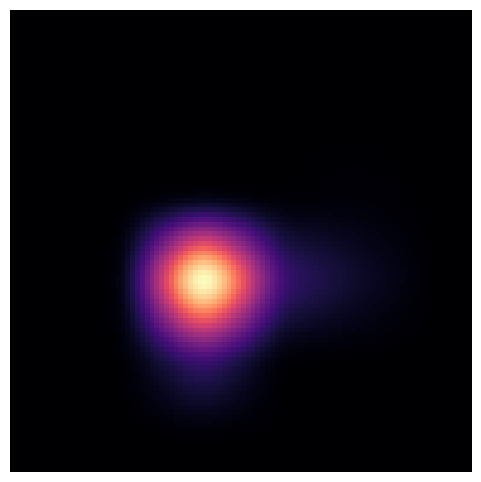

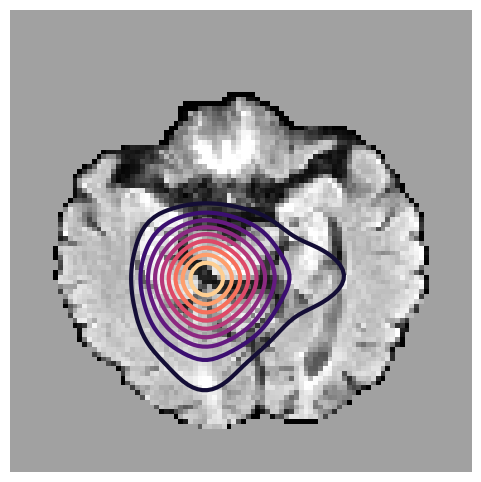

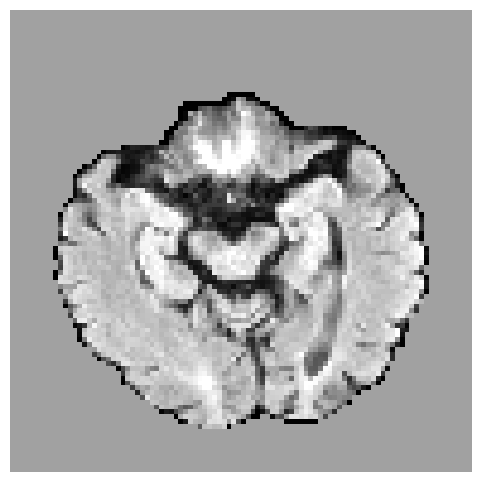

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the NIfTI files 
mri_nifti_path = f'./inference/saliency_maps/sample_0000_label_0.00_image.nii.gz' 
saliency_nifti_path = f'./inference/saliency_maps/sample_0000_label_0.00_saliencymap_layer-1.nii.gz'

mri_img = nib.load(mri_nifti_path)
saliency_img = nib.load(saliency_nifti_path)
mri_data = mri_img.get_fdata()
saliency_data = saliency_img.get_fdata()

print(mri_data.shape, saliency_data.shape, np.max(mri_data), np.max(saliency_data))

# Select a 2D slice based on a index number 
slice_idx = mri_data.shape[2] // 2 -15
mri_slice = mri_data[:, :, slice_idx]
saliency_slice = saliency_data[:, :, slice_idx]

# Normalize the MRI slice using robust normalization (1st and 99th percentiles)
def normalize_image(img):
    p1, p99 = np.percentile(img, (1, 99))
    img_clipped = np.clip(img, p1, p99)
    img_normalized = (img_clipped - p1) / (p99 - p1)
    return img_normalized

mri_slice_norm = normalize_image(mri_slice)

# Normalization function 
def normalize_saliency(saliency):
    saliency[saliency < 0] = 0
    if np.max(saliency) > 0:
        saliency_normalized = saliency / np.max(saliency)
    else:
        saliency_normalized = saliency
    return saliency_normalized

# Apply Gaussian blur to smooth the saliency map and normalize
saliency_slice_blurred = cv2.GaussianBlur(saliency_slice, (15, 15), 0)
saliency_slice_norm = normalize_saliency(saliency_slice_blurred)

# Apply a threshold to the saliency map
threshold_value = 0.0 
saliency_slice_thresholded = np.where(saliency_slice_norm > threshold_value, saliency_slice_norm, 0)

#  thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(saliency_slice_thresholded.T, cmap='magma', interpolation='none', origin='lower')
plt.axis('off')  

#  MRI slice with contour overlay of the thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.contour(saliency_slice_thresholded.T, levels=10, cmap='magma', origin='lower', linewidths=3)  # Adjust the linewidth value as needed
plt.axis('off')  


#  MRI slice alone 
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.axis('off') 


plt.show()  
